In [2]:
from pipeline import *
from utils import *

## 1. Read raw datacube and remove background & fringe

In [2]:
raw_datacube = read_raw_SITELLE_datacube("/home/qliu/data/A2390C4new.fits",name="A2390C")
raw_datacube.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2064                                                  
NAXIS3  =                  124                                                  
EXTEND  =                    T                                                  
DATE    = '2017-09-29'         / Creation date                                  
MASK    = 'False   '                                                            
FILETYPE= 'Calibrated Spectrum Cube' / Type of file                             
OBSERVAT= 'CFHT    '           / Observatory name                               
TELESCOP= 'CFHT 3.6m'          / Hawaii Big Island, Mauna Kea                   
INSTRUME= 'SITELLE '        

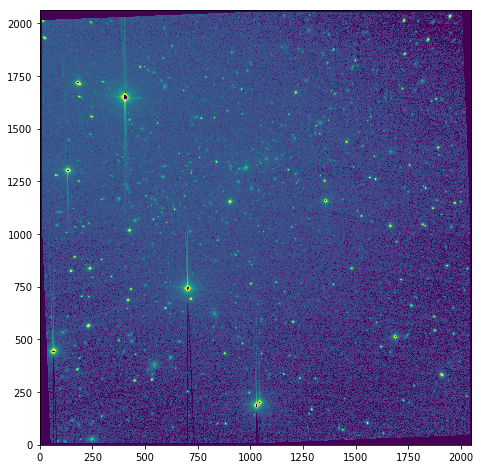

In [3]:
plt.figure(figsize=(8,8))
plt.imshow(raw_datacube.raw_stack_field, norm=norm1, origin="lower", vmin=6, vmax=100)

In [16]:
raw_datacube.save_mask_edge(save_path = './proc/')

In [4]:
raw_datacube.remove_background(box_size=128, save_path='./A2390C/fig/bkg/128/', plot=False)

Removing background... Channel: 10
Removing background... Channel: 20
Removing background... Channel: 30
Removing background... Channel: 40
Removing background... Channel: 50


In [6]:
raw_datacube.remove_fringe(channels=[1,2,3,4,5,51,52], save_path='./A2390C/fig/bkg/128/', plot=True)

Removing fringe... Channel: 1
Removing fringe... Channel: 2
Removing fringe... Channel: 3
Removing fringe... Channel: 4
Removing fringe... Channel: 5
Removing fringe... Channel: 51
Removing fringe... Channel: 52


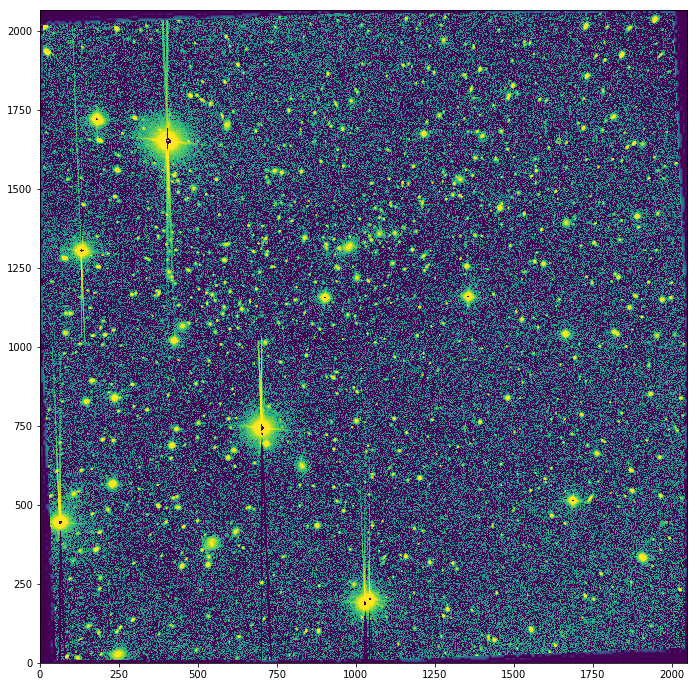

In [76]:
plt.figure(figsize=(12,12))
plt.imshow(raw_datacube.stack_field, norm=norm1, origin="lower", vmin=0, vmax=3)

In [ ]:
raw_datacube.save_weight_map(region_path="./A2390C/A2390C_mask.reg", weight=0.001, save_path = './proc/')

In [9]:
raw_datacube.save_fits(save_path = './proc/', suffix="")

Saving background & fringe subtracted datacube and stacked field...


## 2. Extract source and spectra from datacube 

In [1]:
from pipeline import *
from utils import *

In [2]:
datacube = Read_Datacube('./proc/A2390C_cube.fits', z0=0.228, name='A2390C', 
                         mask_edge='./proc/Raw_stack_A2390C_mask.fits', mode="MMA")

In [3]:
src_map, segm, seg_map = datacube.ISO_source_detection(sn_thre=2.5, nlevels=64, contrast=0.01, box=(3,3,3),
                                                       closing=True, save=True, save_path = './proc/', suffix="")

Use the map of maximum of moving average (MMA) to detect source.
Box shape:  (3, 3, 3)
Detecting and deblending source...


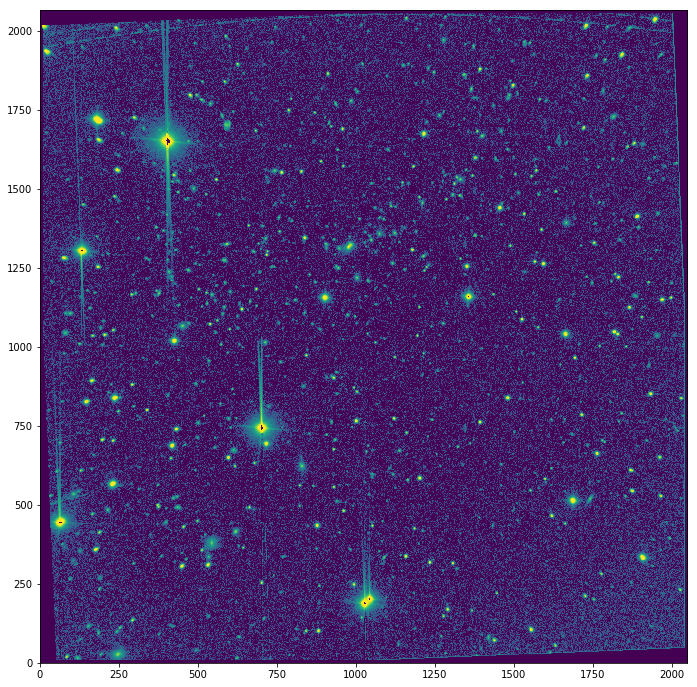

In [4]:
plt.figure(figsize=(12,12))
plt.imshow(datacube.src_map, norm=norm1, origin="lower", vmin=np.median(datacube.src_map), vmax=1)

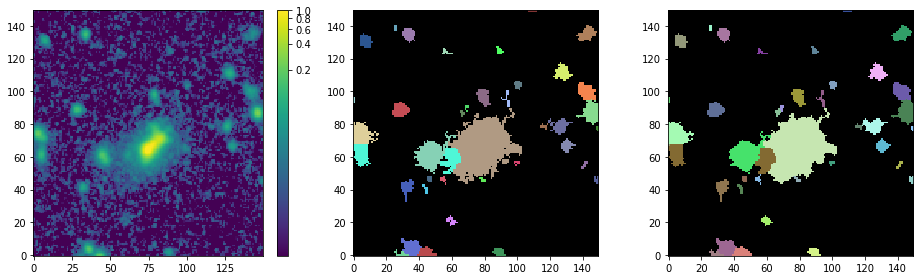

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
im1 = ax1.imshow(src_map[1250:1400,900:1050], norm=norm1, aspect="auto",origin="lower", vmin=np.median(src_map), vmax=1)
colorbar(im1)   
im2 = ax2.imshow(segm.data[1250:1400,900:1050], origin="lower", cmap=segm.make_cmap())
im3 = ax3.imshow(seg_map[1250:1400,900:1050], origin="lower", cmap=segm.make_cmap()) 
plt.tight_layout()

In [9]:
datacube.ISO_spec_extraction_all(seg_map)

Extract spectra... 400/2877
Extract spectra... 800/2877
Extract spectra... 1200/2877
Extract spectra... 1600/2877
Extract spectra... 2000/2877
Extract spectra... 2400/2877
Extract spectra... 2800/2877


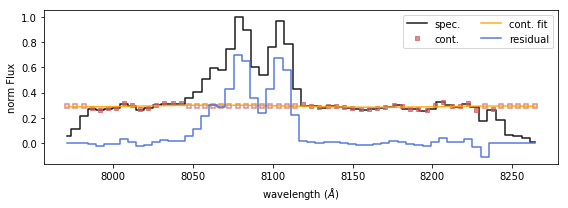

In [7]:
res, wavl_rebin, cont_fit = fit_continuum(datacube.obj_specs_opt[2670], datacube.wavl, edge_ratio=0.1)

In [10]:
datacube.fit_continuum_all(model='GP', plot=False, save_path='./A2390C/fig_iso/fit_cont_MMA/')

Fit continuum with GP. No edge_ratio is given. Use estimate = 0.07
Fit spectra continuum ... 200/2877
Fit spectra continuum ... 400/2877
Fit spectra continuum ... 600/2877
Fit spectra continuum ... 800/2877
Fit spectra continuum ... 1000/2877
Fit spectra continuum ... 1200/2877
Fit spectra continuum ... 1400/2877
Fit spectra continuum ... 1600/2877
Fit spectra continuum ... 1800/2877
Fit spectra continuum ... 2000/2877
Fit spectra continuum ... 2200/2877
Fit spectra continuum ... 2400/2877
Fit spectra continuum ... 2600/2877
Fit spectra continuum ... 2800/2877
Skip spurious detection:  #115 #498 #2501 #2503 #2504 #2506 #2508 #2509 #2513 #2514 #2515 #2516 #2519 #2521 #2522 #2523 #2526 #2527 #2534 #2538 #2540 #2542 #2544 #2546 #2549 #2550 #2551 #2554 #2558 #2561 #2563 #2566 #2568 #2572 #2575 #2582 #2585 #2591 #2596 #2597 #2719 #2720  ... Replaced with random noise.
Continuum Fitting Finished!


In [11]:
datacube.save_spec_fits(save_path='./proc/', suffix="_all")

### Comparison

In [16]:
hdu_spec = fits.open('./A2390C/A2390C-spec_v4.fits')
obj_nums = hdu_spec[0].data
obj_specs_opt = hdu_spec[3].data
wavl_rebin = hdu_spec[6].data

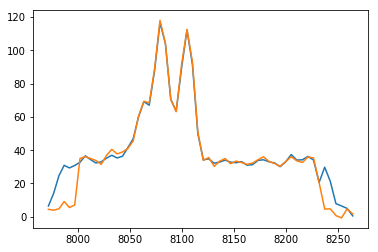

In [14]:
plt.plot(datacube.wavl, datacube.obj_specs_opt[2073])
plt.plot(datacube.wavl, obj_specs_opt[1935])

## 3. Generate Templates

In [15]:
from pipeline import *
from utils import *

In [13]:
datacube = Read_Datacube('./proc/A2390C_cube.fits', 
                         name='A2390C', z0=0.228, mode="MMA",
                         table='./proc/A2390C_MMA.dat', 
                         seg_map='./proc/A2390C_segm_MMA.fits')

In [17]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2, 
                           temp_type="OII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.), 
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8),
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='gauss')

Template: OII_gauss  Total Number: 10
Template: Hb-OIII_gauss  Total Number: 80
Template: Ha-NII_gauss  Total Number: 400


Template: Ha-NII_box  Total Number: 40


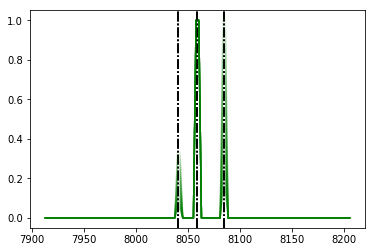

In [5]:
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8), temp_params={'box_width':3},
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='box', plot=True)

In [6]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2,
                           temp_type="OII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.),
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8), 
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='box')

Template: OII_box  Total Number: 1
Template: Hb-OIII_box  Total Number: 8
Template: Ha-NII_box  Total Number: 40


In [7]:
for mod in ['gauss','box']:
    for typ in ["Ha-NII", "Hb-OIII", "OII"]:
        datacube.Save_Template(save_path='./proc/temp/', temp_type=typ, temp_model=mod)

Save A2390C templates for Ha-NII_gauss
Save A2390C templates for Hb-OIII_gauss
Save A2390C templates for OII_gauss
Save A2390C templates for Ha-NII_box
Save A2390C templates for Hb-OIII_box
Save A2390C templates for OII_box


## 4. Cross-correlation

In [1]:
from pipeline import *
from utils import *

In [14]:
datacube = Read_Datacube('./proc/A2390C_cube.fits', 
                         name='A2390C', z0=0.228, mode="MMA",
                         table='./proc/A2390C_MMA.dat', 
                         seg_map='./proc/A2390C_segm_MMA.fits',
                         mask_edge='./proc/Raw_stack_A2390C_mask.fits')

datacube.read_spec('./proc/A2390C-spec-MMA_all.fits')

In [15]:
datacube.Read_Template('./proc/temp/', n_intp=2)

Read Emission Line Template:
['./proc/temp/Template-A2390C_Ha-NII_gauss.fits',
 './proc/temp/Template-A2390C_Hb-OIII_gauss.fits',
 './proc/temp/Template-A2390C_OII_gauss.fits',
 './proc/temp/Template-A2390C_Ha-NII_box.fits',
 './proc/temp/Template-A2390C_Hb-OIII_box.fits',
 './proc/temp/Template-A2390C_OII_box.fits']


Best z: 0.231 Best sigma: 5.813
Peak wavl 8078.020
Detection #2671  z: 0.231  Peak R: 1.590  Detction S/N: 79.011 Peak S/N: 10.754


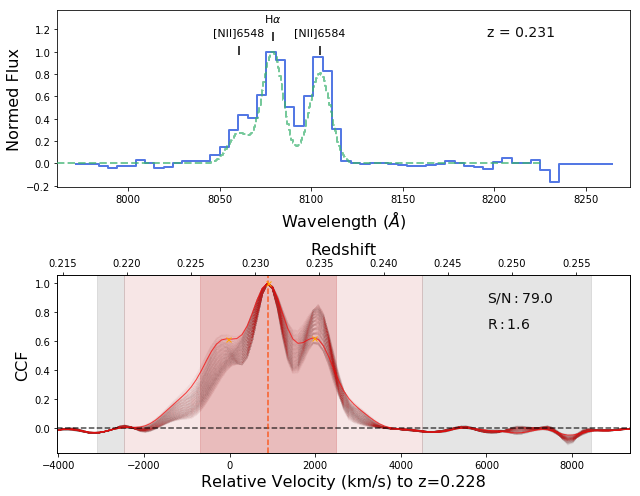

In [6]:
result = datacube.cross_correlation(2671, temp_type="Ha-NII", const_window=False, temp_model="gauss")

Best z: 0.238 Best sigma: 3.817
Peak wavl 8124.149
Detection #2286  z: 0.238  Peak R: 3.092  Detction S/N: 26.011 Peak S/N: 12.846


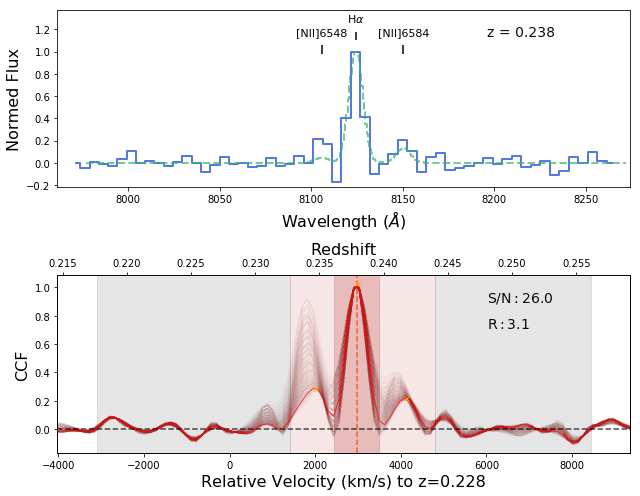

In [5]:
result = datacube.cross_correlation(2286, temp_type="Ha-NII", edge=20, const_window=False, temp_model="gauss")

Best z: 0.635 Best sigma: 3.018
Peak wavl 8186.064
Detection #67  z: 0.635  Peak R: 3.718  Detction S/N: 12.398 Peak S/N: 12.398


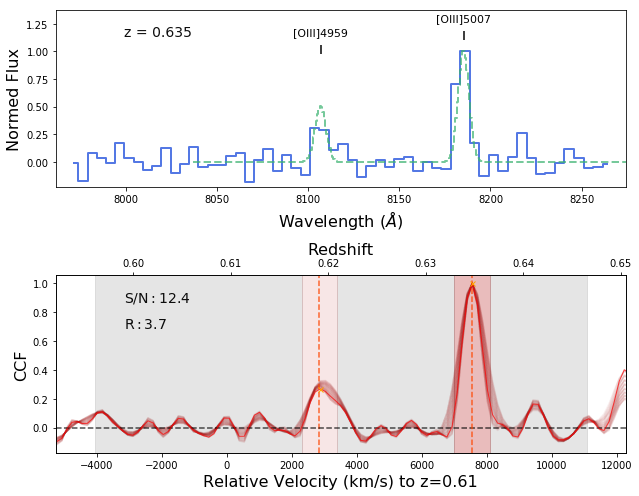

In [7]:
result = datacube.cross_correlation(67, temp_type="Hb-OIII", edge=20, const_window=False, temp_model="gauss")

Best z: 1.182 Best sigma: 5.813
Peak wavl 8134.436
Detection #148  z: 1.182  Peak R: 1.000  Detction S/N: 6.028 Peak S/N: 6.028


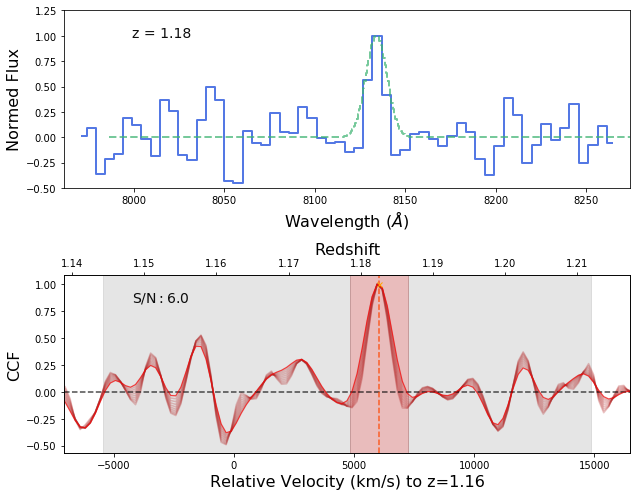

In [4]:
result = datacube.cross_correlation(148, temp_type="OII", edge=20, const_window=True, temp_model="gauss")

In [41]:
# datacube.cross_correlation_all(temp_type="Ha-NII", temp_model="gauss", const_window=False, verbose=False)
datacube.cross_correlation_all(temp_type="Hb-OIII", temp_model="gauss", const_window=False, verbose=False)
# datacube.cross_correlation_all(temp_type="OII", temp_model="gauss", const_window=False, verbose=False)

Do cross-correlation using Hb-OIII_gauss model templates...


In [42]:
# datacube.cross_correlation_all(temp_type="Ha-NII", temp_model="box", verbose=False)
datacube.cross_correlation_all(temp_type="Hb-OIII", temp_model="box", verbose=False)
# datacube.cross_correlation_all(temp_type="OII", temp_model="box", verbose=False)

Do cross-correlation using Hb-OIII_box model templates...


In [44]:
datacube.save_cc_result(save_path='./proc/')

Save cross-correlation results for A2390C as : ./proc/A2390C-cc.pkl
Template used: ['Ha-NII_gauss', 'OII_gauss', 'Ha-NII_box', 'OII_box', 'Hb-OIII_gauss', 'Hb-OIII_box']


## 5. Select Candidate

In [1]:
from pipeline import *
from utils import *

In [2]:
datacube = Read_Datacube('./proc/A2390C_cube.fits', 
                         name='A2390C', z0=0.228, mode="MMA",
                         table='./proc/A2390C_MMA.dat', 
                         seg_map='./proc/A2390C_segm_MMA.fits',
                         mask_edge='./proc/Raw_stack_A2390C_mask.fits')

datacube.deep_frame =  fits.open('./proc/A2390C_DF.fits')[0].data
datacube.src_map = fits.open('./proc/A2390C_MMA.fits')[0].data
datacube.read_spec('./proc/A2390C-spec-MMA_all.fits')
datacube.Read_Template('./proc/temp/', n_intp=2)
datacube.read_cc_result('./proc/A2390C-cc.pkl')

In [113]:
SNR_best_Ha_gauss = datacube.get_CC_result_best('SNR', 'Ha-NII_gauss')
SNR_best_OIII_gauss = datacube.get_CC_result_best('SNR', 'Hb-OIII_gauss')
SNR_best_OII_gauss = datacube.get_CC_result_best('SNR', 'OII_gauss')

SNR_best_Ha_box = datacube.get_CC_result_best('SNR', 'Ha-NII_box')
SNR_best_OII_box = datacube.get_CC_result_best('SNR', 'OII_box')

z_best_OIII_gauss = datacube.get_CC_result_best('z_best', 'Hb-OIII_gauss')
flag_e_Ha_gauss = datacube.get_CC_result_best('flag_e', 'Ha-NII_gauss')


### Match with SDSS stars

In [5]:
cat_match = datacube.match_sdss_star(sep=3*u.arcsec, search_radius=7*u.arcmin, band='rmag')

c_match_star = SkyCoord(ra=cat_match["RA_ICRS"], dec=cat_match["DE_ICRS"])
star_match_pos = np.array(c_match_star.to_pixel(datacube.wcs, origin=0)).T

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


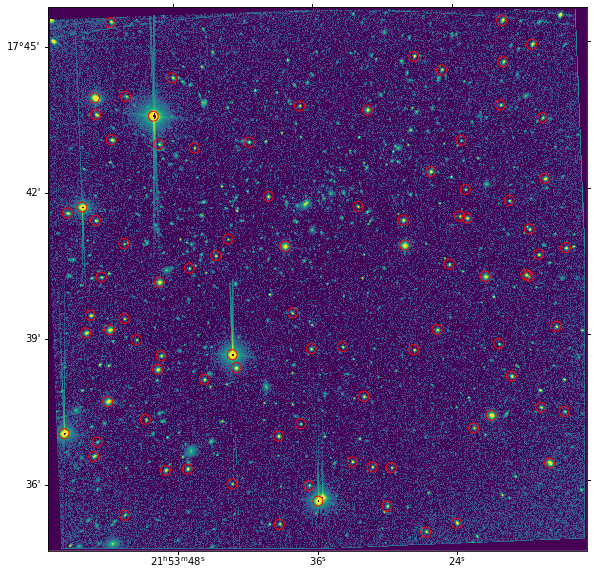

In [6]:
plt.figure(figsize=(10,10))
ax = plt.subplot(projection=datacube.wcs)
plt.scatter(star_match_pos[:,0], star_match_pos[:,1], s=100, facecolor="none", edgecolor="r")
plt.imshow(datacube.src_map, norm=norm1, origin="lower", vmin=np.median(datacube.src_map), vmax=1)

### Measure distance

In [68]:
dist_to_edge = measure_dist_to_edge(datacube.table, datacube.mask_edge, pad=200)
good_channel = np.argmax(datacube.obj_specs_opt, axis=1)!=3

### Measure EW

(100.6833136203123, 4.126283081135687)

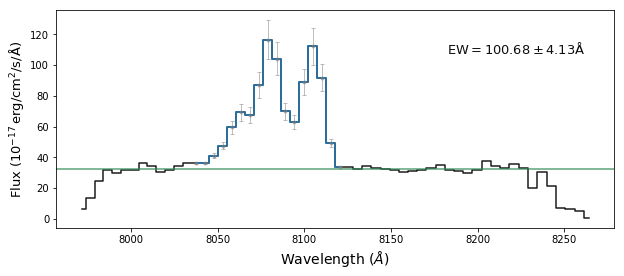

In [8]:
datacube.estimate_EW(2671, MC_err=True)

(59.4986727422611, 5.554108406545756)

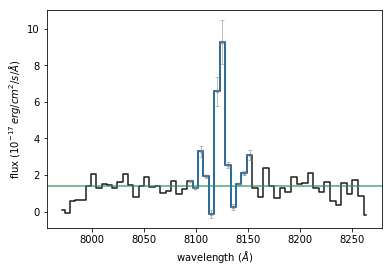

In [8]:
datacube.estimate_EW(2286, MC_err=True)

(59.4986727422611, 5.814697789720852)

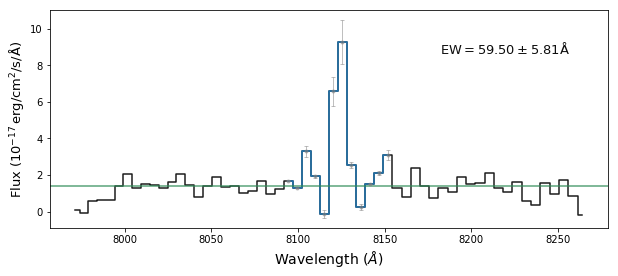

In [8]:
datacube.estimate_EW(2286, MC_err=True)

In [9]:
datacube.estimate_EW_all(MC_err=True)

Measure EW... 400/2877
Measure EW... 800/2877
Measure EW... 1200/2877
Measure EW... 1600/2877
Measure EW... 2000/2877
Measure EW... 2400/2877
Measure EW... 2800/2877


### Conditions

In [170]:
EW_cond = (datacube.EWs > 3*datacube.EW_stds) & (datacube.EWs > 5)
edge_cond = dist_to_edge > 5

SNR_min_gauss = np.min([SNR_best_Ha_gauss, SNR_best_OIII_gauss, SNR_best_OII_gauss], axis=0)
SNR_min_cond = SNR_min_gauss > 3

SNR_cond_A = (SNR_best_Ha_gauss > 8) & (SNR_best_OII_gauss>3) & (SNR_best_OIII_gauss > SNR_best_Ha_gauss)
SNR_cond_B = (SNR_best_Ha_gauss > 5) & (SNR_best_Ha_gauss <= 8) & (SNR_best_OII_gauss>5)

zmin_OIII = datacube.wavl.min()/4959-1
SNR_cond_C = (SNR_best_OIII_gauss > np.max([5*np.ones_like(datacube.obj_nums),
                                            SNR_best_Ha_gauss, SNR_best_OII_gauss], axis=0)) \
            & SNR_min_cond & (z_best_OIII_gauss>zmin_OIII)

num_c = datacube.obj_nums[EW_cond & SNR_cond_A & edge_cond & good_channel]

num_c = np.setdiff1d(num_c, cat_match["NUMBER"])
num_c = np.setdiff1d(num_c, datacube.num_spurious)


In [171]:
len(num_c)

8

In [169]:
for k, num in enumerate(num_c):
    if np.mod(k+1, 40)==0: print("Plot: %d/%d"%(k+1, len(num_c)))
    datacube.plot_candidate(num, temp_type="Ha-NII", temp_model="gauss")
    plt.savefig("./A2390C/fig_iso/candidate/A/#%d.png"%num,dpi=75)
    plt.title("Sample A")
    plt.close()

Plot: 40/82
Plot: 80/82


Detection #204  z: 0.645  sigma: 4.615  Peak R: 9.617  Detction S/N: 5.794 Peak S/N: 5.794


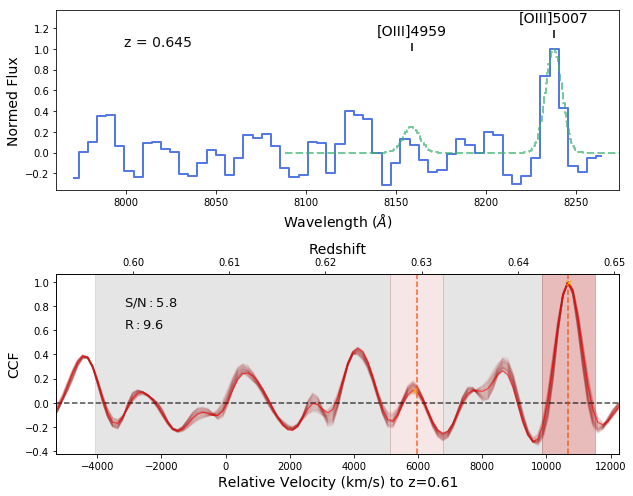

In [173]:
result = datacube.cross_correlation(204, temp_type="Hb-OIII", edge=20, const_window=False, temp_model="gauss")

Detection #726  z: 0.232  sigma: 4.615  Peak R: 8.394  Detction S/N: 3.420 Peak S/N: 3.372


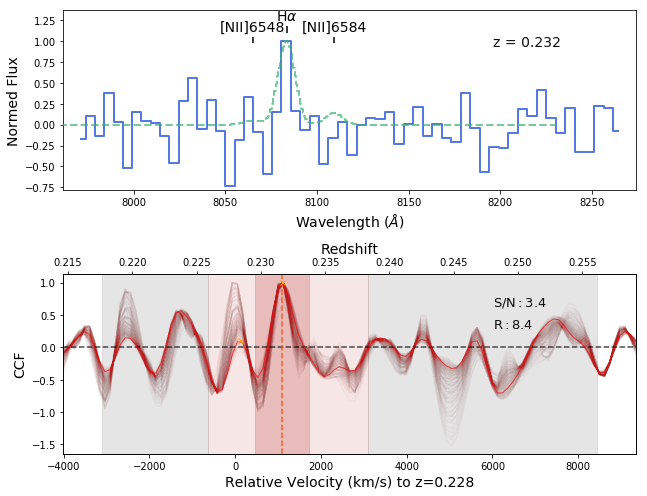

In [176]:
result = datacube.cross_correlation(726, temp_type="Ha-NII", edge=20, const_window=False, temp_model="gauss")

## 6. Measure Centroid

In [8]:
from pipeline import *
from utils import *

In [9]:
datacube = Read_Datacube('./proc/A2390C_cube.fits', 
                         name='A2390C', z0=0.228, mode="MMA",
                         table='./proc/A2390C_MMA.dat', 
                         seg_map='./proc/A2390C_segm_MMA.fits',
                         deep_frame='./proc/A2390C_DF.fits',
                         mask_edge='./proc/Raw_stack_A2390C_mask.fits')
datacube.get_wcs()
datacube.src_map = fits.open('./proc/A2390C_MMA.fits')[0].data
datacube.read_spec('./proc/A2390C-spec-MMA_all.fits')
datacube.Read_Template('./proc/temp/', n_intp=2)
datacube.read_cc_result('./proc/A2390C-cc.pkl')

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Read Emission Line T

In [10]:
el_v = glob.glob("./A2390C/fig_iso/candidate/V/#*.png")
Num_v = np.sort(np.array([re.compile(r'\d+').findall(el)[-1] for el in el_v]).astype("int"))
Num_v

array([  47,   67,  148,  207,  215,  226,  276,  297,  338,  389,  406,
        428,  443,  459,  534,  552,  617,  622,  633,  688,  692,  703,
        737,  783,  795,  800,  835,  841,  885,  935,  941, 1057, 1059,
       1085, 1091, 1142, 1144, 1161, 1165, 1175, 1181, 1185, 1258, 1316,
       1322, 1355, 1356, 1385, 1396, 1421, 1442, 1501, 1514, 1520, 1573,
       1616, 1673, 1690, 1698, 1708, 1730, 1733, 1745, 1788, 1802, 1819,
       1837, 1840, 1844, 1847, 1857, 1868, 1901, 1943, 1968, 1979, 1982,
       1990, 1999, 2006, 2007, 2008, 2023, 2089, 2102, 2109, 2110, 2114,
       2144, 2157, 2191, 2208, 2214, 2221, 2243, 2273, 2286, 2289, 2291,
       2314, 2320, 2332, 2343, 2345, 2354, 2356, 2429, 2543, 2555, 2616,
       2665, 2671, 2677, 2685, 2704, 2712, 2713, 2721, 2755, 2756, 2759,
       2760, 2768, 2790, 2791, 2792, 2811, 2820])

In [11]:
id_BCG = np.argmin((datacube.table['xcentroid']-980)**2 + (datacube.table['ycentroid']-1315)**2)
pos_BCG = datacube.assign_BCG_position(id_BCG=id_BCG)

ra_BCG, dec_BCG = datacube.wcs.all_pix2world(datacube.pos_BCG[0], datacube.pos_BCG[1], 1)
datacube.assign_BCG_coordinate((ra_BCG,dec_BCG))

BCG coordinate:  21h53m36.8153s +17d41m43.8089s


In [12]:
obj = Obj_detection(datacube.table[2670], from_SE=False, cube=datacube.cube,
                    seg_map=datacube.seg_map, deep_frame=datacube.deep_frame, mask_edge=datacube.mask_edge)

In [44]:
# datacube.centroid_analysis(num=1968, centroid_type='APER',coord_type="angular")